<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/HW_03/HW_03_T01_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install wandb

In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pickle
from torch.utils.data import DataLoader
import torchvision
from matplotlib import pyplot as plt
import time

In [3]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
MODEL_SAVE_PATH = './gdrive/My Drive/VAE.pt'

In [5]:
!wandb login

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 2377ef66e63c2eda02e1d83797d0cc73170988c7
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [6]:
import wandb
wandb.init(project="dul")

W&B Run: https://app.wandb.ai/ram_saw/dul/runs/zkunk036

In [7]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [0]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [0]:
def print_data_info(X, y, label):
    print(f'Data info for {label}')
    print(X.shape)
    print(y.shape)
    print(X[1])
    print(y[1])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(['red','green','blue']))
    plt.show()

Data info for all dataset
(99999, 2)
(99999,)
[-1.91759247 -0.12925264]
2


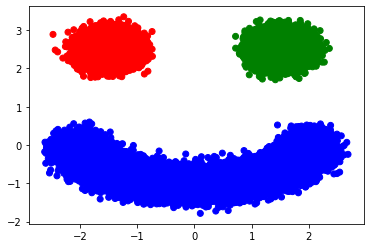

In [10]:
X, Y = sample_data_3()
print_data_info(X, Y, 'all dataset')

Data info for train
torch.Size([79999, 2])
torch.Size([79999])
tensor([-1.8588, -0.3814])
tensor(2.)


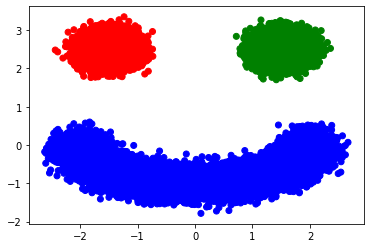

Data info for test
torch.Size([20000, 2])
torch.Size([20000])
tensor([ 1.5242, -0.3453])
tensor(2.)


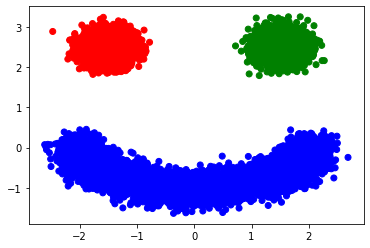

In [11]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.2, random_state=SEED)
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = torch.FloatTensor(X_TRAIN), torch.FloatTensor(X_TEST), torch.FloatTensor(Y_TRAIN), torch.FloatTensor(Y_TEST)
print_data_info(X_TRAIN, Y_TRAIN, 'train')
print_data_info(X_TEST, Y_TEST, 'test')

In [12]:
X_Y_TRAIN = torch.cat((X_TRAIN, Y_TRAIN.unsqueeze(1)), dim=1)
X_Y_TEST = torch.cat((X_TEST, Y_TEST.unsqueeze(1)), dim=1)
print(X_Y_TRAIN.shape)
print(X_Y_TEST.shape)

torch.Size([79999, 3])
torch.Size([20000, 3])


In [0]:
class IsotropicNormal(nn.Module):
    def __init__(self, n_layers=5, n_features=512):
        super(IsotropicNormal, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        self.inlayer = nn.Linear(2, self.n_features)
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 4)
            
    def forward(self, x):
        x = torch.relu(self.inlayer(x))
        for layer in self.layers:
            x = torch.relu(layer(x)) + x
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var)
        return mu, var

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = IsotropicNormal()
        self.decoder = IsotropicNormal()
        self.prior = MultivariateNormal(torch.zeros(2), torch.diag_embed(torch.ones(2)))
    
    def forward(self, x):
        mu_z, var_z = self.encode(x)
        z = self.sample_normal(mu_z, var_z)
        mu_x, var_x = self.decode(z)
        return mu_z, var_z, z, mu_x, var_x
      
    def loss(self, x):
        mu_z, var_z, z, mu_x, var_x = self.forward(x)
        nll = torch.sum(-0.5 * (torch.log(np.pi * 2 * var_x) + torch.pow(x - mu_x, 2) / var_x), dim=1, keepdim=True)
        nll = -torch.sum(nll, dim=1, keepdim=True)
        kl_divergence = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
        kl_divergence = -0.5 * torch.sum(kl_divergence, dim=1, keepdim=True)
        return nll, kl_divergence

    def encode(self, x):
        return self.encoder(x)

    def sample(self, n):
        z = self.prior.rsample((n,)).to(DEVICE)
        mu_x, var_x = self.decode(z)
        x = self.sample_normal(mu_x, var_x)
        return x, mu_x, var_x

    def sample_normal(self, mu, var):
      return mu + torch.randn(mu.shape).cuda() * torch.sqrt(var)

    def decode(self, z):
        return self.decoder(z)

In [0]:
def train(vae, train_data, test_data, epochs_cnt=400, lr=1e-3, batch_size=10000, val_steps=4, start_epoch=0):
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data = test_data.to(DEVICE)

    nll_values = {'train': [], 'val': []}
    kl_divergence_values = {'train': [], 'val': []}
    vlb_values = {'train': [], 'val': []}

    step = 0
    start = time.time()
    for i in range(start_epoch, epochs_cnt):
        for batch in dataloader:
            vae.train()
            step += 1
            batch = batch.to(DEVICE)
            nll, kl_divergence = vae.loss(batch)
            loss = torch.mean(nll + kl_divergence)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
            optimizer.step()

            nll_values['train'].append(torch.mean(nll).detach().item() / 2.0 / np.log(2))
            kl_divergence_values['train'].append(torch.mean(kl_divergence).detach().item())
            vlb_values['train'].append(torch.mean(-loss).detach().item())
            wandb.log({
                'nll_train': nll_values['train'][-1],
                'kl_divergence_train': kl_divergence_values['train'][-1],
                'vlb_train': vlb_values['train'][-1]
            })
            if step % val_steps == 0:
                vae.eval()
                with torch.no_grad():
                    nll, kl_divergence = vae.loss(val_data)
                    loss = torch.mean(nll + kl_divergence)
                    nll_values['val'].append(torch.mean(nll).detach().item() / 2.0 / np.log(2))
                    kl_divergence_values['val'].append(torch.mean(kl_divergence).detach().item())
                    vlb_values['val'].append(torch.mean(-loss).detach().item())
                    wandb.log({
                        'nll_val': nll_values['val'][-1],
                        'kl_divergence_val': kl_divergence_values['val'][-1],
                        'vlb_val': vlb_values['val'][-1]
                    })
                #print(f"Train loss: {nll_values['train'][-1]} {kl_divergence_values['train'][-1]} {vlb_values['train'][-1]}")
                #print(f"Val loss: {nll_values['val'][-1]} {kl_divergence_values['val'][-1]} {vlb_values['val'][-1]}")
                vae.train()
        if (i + 1) % 100 == 0:
            end = time.time()
            print(f'Model saved in {i + 1} epoch')
            print(f'Elapsed time: {end - start}')
            start = end
            torch.save(vae.state_dict(), MODEL_SAVE_PATH)
    return nll_values, kl_divergence_values, vlb_values

In [0]:
MODEL = VAE().to(DEVICE)

In [17]:
MODEL.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [20]:
NLL, KL_DIVERGENCE, VLB = train(MODEL, X_TRAIN, X_TEST, epochs_cnt=10000, lr=2e-4, batch_size=10000, val_steps=4, start_epoch=3100)

Model saved in 3200 epoch
Elapsed time: 56.71619367599487
Model saved in 3300 epoch
Elapsed time: 56.49631929397583
Model saved in 3400 epoch
Elapsed time: 56.787978410720825
Model saved in 3500 epoch
Elapsed time: 56.849791288375854
Model saved in 3600 epoch
Elapsed time: 56.60458016395569
Model saved in 3700 epoch
Elapsed time: 58.740559816360474
Model saved in 3800 epoch
Elapsed time: 57.780029296875
Model saved in 3900 epoch
Elapsed time: 57.79210376739502
Model saved in 4000 epoch
Elapsed time: 57.429606437683105
Model saved in 4100 epoch
Elapsed time: 57.5172483921051
Model saved in 4200 epoch
Elapsed time: 57.767531394958496
Model saved in 4300 epoch
Elapsed time: 57.60856795310974
Model saved in 4400 epoch
Elapsed time: 57.69687294960022
Model saved in 4500 epoch
Elapsed time: 57.951160192489624
Model saved in 4600 epoch
Elapsed time: 57.25567054748535
Model saved in 4700 epoch
Elapsed time: 57.65933346748352
Model saved in 4800 epoch
Elapsed time: 57.6028413772583
Model saved 

KeyboardInterrupt: ignored

In [0]:
def plot_losses(train_losses, val_losses, label, val_steps):
    plt.title(label)
    plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Train')
    plt.plot(np.arange(1, len(val_losses) + 1) * val_steps, val_losses, label='Validation')
    plt.legend()
    plt.show()

In [0]:
plot_losses(NLL['train'], NLL['val'], 'Decoder Term', 4)

In [0]:
plot_losses(KL_DIVERGENCE['train'], KL_DIVERGENCE['val'], 'KL Divergence', 4)

In [0]:
plot_losses(VLB['train'], VLB['val'], 'Variational Lower Bound', 4)

In [0]:
def draw_vae_samples(vae_model, n):
    x, mu_x, var_x = vae_model.sample(n)
    x = x.cpu().detach().numpy()
    mu_x = mu_x.cpu().detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], marker='.', label="Samples From Full Generation Path")
    plt.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label="Without Decoder Noise")
    plt.legend()

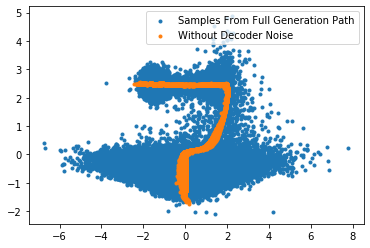

In [25]:
draw_vae_samples(MODEL, 100000)

In [0]:
torch.save(MODEL.state_dict(), './gdrive/My Drive/VAE_5_5000.pt')